# Acoustics with Godunov's method and Lax-Friedrichs

A simple implementation of Godunov's method and Lax-Friedrichs for constant coefficient acoustics.

Modified to include dt in function calls, and to better illustrate the solution after 1 or more steps.

In [1]:
%matplotlib inline

In [2]:
from pylab import *

In [3]:
from IPython.display import HTML

In [4]:
try:
    from clawpack.visclaw import animation_tools
except:
    print("Failed to load animation_tools from Clawpack")

Failed to load animation_tools from Clawpack


### Define the domain and material parameters for acoustics:

In [30]:
# domain:
xlower = 0.
xupper = 1.

# material parameters:
K0 = 2
rho0 = 2
c0 = sqrt(K0/rho0)
print('sound speed c0 = %.3f' % c0)
Z0 = sqrt(K0*rho0)
print('impedance Z0 = %.3f' % Z0)

sound speed c0 = 1.000
impedance Z0 = 2.000


## Function to take a single time step:

For simplicity, this function has only two inputs, the arrays of `Pn` $=P^n$ and `Un` $=U^n$ containing the pressure and velocity at some time t_n.

It returns the updated arrays `Pnp` $= P^{n+1}$ and `Unp` $= U^{n+1}$ at the end of the time step.

This function uses values set above for the material parameters set above.  
It should work regardless of the number of grid cells in the arrays (provided `Pn` and `Un` have the same length), and now take `dt` as a parameter.  So you only need to re-execute if you change the material parameters.

In [203]:
def Godunov_step(Pn,Un,dt):
    # initialize new cell averages at n+1 to old ones at n:
    # important to make a copy so we can modify without change old values!
    Pnp = Pn.copy()
    Unp = Un.copy()

    # fill ghost cells for periodic BCs:
    # fill at t_n so these values can be used in computing updates
    Pn[0] = Pn[-2]
    Pn[-1] = Pn[1]
    Un[0] = Un[-2]
    Un[-1] = Un[1]
    
    # loop over interfaces where Riemann problem will be solved:
    for i in range(1,len(x)):
        
        # solve Riemann problem between i-1 and i:
        
        # left and right states (using old values at t_n):
        PL = Pn[i-1]; PR = Pn[i]
        UL = Un[i-1]; UR = Un[i]
        
        # coefficients of eigenvectors in W^p = alpha^p * r^p:
        # from (3.31) in FVMHP
        alpha1 = (-(PR-PL) + Z0*(UR-UL)) / (2*Z0)
        alpha2 = ((PR-PL) + Z0*(UR-UL)) / (2*Z0)
        
        # wave speeds (eigenvalues):
        s1 = -c0
        s2 = c0
        
        # left-going wave W1 updates cell i-1:

        Pnp[i-1] = Pnp[i-1] - dt/dx * s1 * alpha1 * (-Z0)
        Unp[i-1] = Unp[i-1] - dt/dx * s1 * alpha1 * 1.
        
        # right-going wave W2 updates cell i:
        Pnp[i] = Pnp[i] - dt/dx * s2 * alpha2 * Z0
        Unp[i] = Unp[i] - dt/dx * s2 * alpha2 * 1.
        
    return Pnp, Unp

In [204]:
def LxF_step(Pn,Un,dt):
    # initialize new cell averages at n+1 to old ones at n:
    # important to make a copy so we can modify without change old values!
    Pnp = Pn.copy()
    Unp = Un.copy()

    # fill ghost cells for periodic BCs:
    # fill at t_n so these values can be used in computing updates
    Pn[0] = Pn[-2]
    Pn[-1] = Pn[1]
    Un[0] = Un[-2]
    Un[-1] = Un[1]
    
    # loop over gridpoints to apply the timestep:
    for i in range(1,len(x)-1):
        
        Pnp[i] = (Pn[i+1]+Pn[i-1])/2 - dt/(2*dx) * K0 * (Un[i+1]-Un[i-1])
        Unp[i] = (Un[i+1]+Un[i-1])/2 - dt/(2*dx) * (1/rho0) * (Pn[i+1]-Pn[i-1])
        
    return Pnp, Unp

### Function to plot a numerical solution at one time:

In [205]:
def plotQ(Pn,Un,tn):
    subplot(2,1,1)
    plot(x[1:-1], Pn[1:-1], 'bo-')
    xlim(xlower,xupper)
    title('pressure at time %.3f' % tn)
    
    subplot(2,1,2)
    plot(x[1:-1], Un[1:-1], 'bo-')
    xlim(xlower,xupper)
    title('velocity at time %.3f' % tn)
    tight_layout() 

### Time stepping:

Executing the next cell repeatedly will take a time step and plot the new solution

In [206]:
def time_stepper(t0, P0, U0, dt, nsteps, one_step=Godunov_step):
    """
    Take nsteps with time step dt, starting with initial data (P0,U0) at time t0.
    To take a single step use the method specified by one_step, which
    defaults to Godunov_step since that is the only method currently defined.
    But you might want to define a new method for comparison.
    """
    Pn = P0.copy()
    Un = U0.copy()
    for n in range(nsteps):
        Pn,Un = one_step(Pn, Un, dt)
    return Pn,Un

## Perform some numerical experiments

We perform the same experiments as before with a Lax-Friedrichs step.

### Define the numerical grid

We define a finite volume grid with `num_cells` interior points, indexed `1,2,...,num_cells`.  The cell centers start at `dx/2`.  There is also one "ghost cell" on either side.  This works great in Python since array indexing starts at 0, but in Matlab with 1-based indexing the ghost cell would have index 1.  Also if more than 1 ghost cell is used, the indexing will change. 

In [207]:
num_cells = 50
dx = (xupper - xlower)/num_cells

# cell centers, including one ghost cell on either side:
x = arange(xlower-dx/2, xupper+dx, dx)

print('including 2 ghost cells, the grid has %i cells' % len(x))

including 2 ghost cells, the grid has 52 cells


### Initial conditions:

The arrays P0 and U0 should be numpy arrays of length `num_cells + 2` with `dtype = float`.  Make sure they aren't integer arrays!

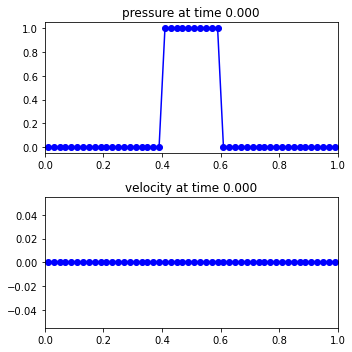

In [208]:
#P0 = exp(-150*(x-0.5)**2)
P0 = where(logical_and(x>0.4,x<0.6), 1., 0.)

U0 = zeros(x.shape)
#U0 = -P0 / Z0  # only left-going wave
#U0 = P0 / Z0  # only right-going wave

t0 = 0.
fig = figure(figsize=(5,5))
plotQ(P0,U0,t0)

### Take several time steps and plot final solution:

Using dt = 0.0180, cfl = 0.90, taking 20 steps to time 0.360


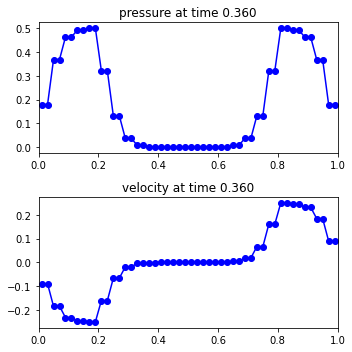

In [209]:
dt = 0.018
cfl = c0*dt/dx
nsteps = 20
tn = t0 + nsteps*dt

print('Using dt = %.4f, cfl = %.2f, taking %i steps to time %.3f' \
      % (dt,cfl,nsteps,tn))

Pn,Un = time_stepper(t0, P0, U0, dt, nsteps, LxF_step)
fig = figure(figsize=(5,5))
plotQ(Pn,Un,tn)

Note that there are always two adjacent points with exactly the same value in this approximate solution. This is due to the fact that our initial condition for $p$ has discontinuities and our numerical method looks at differences between points. The discontinuity results in a large difference between two sets of points and since we look at $p_{i+1}$ and $p_{i-1}$ and not adjacent points, we get two identical differences instead of one. This propogates as time goes on, leading to the bahvior we see in the plots.

### Second experiment - refine the grid

Try the same test but with 100 cells instead of 50, with the time step also reduced by a factor of 2, and now taking 40 time steps to reach the same time as with 20 steps before.

Now all the setup and plotting has been combined into a single cell...

including 2 ghost cells, the grid has 102 cells
Using dt = 0.0090, cfl = 0.90, taking 40 steps to time 0.360


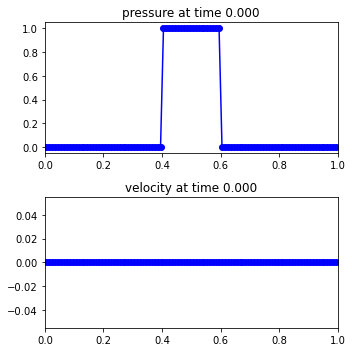

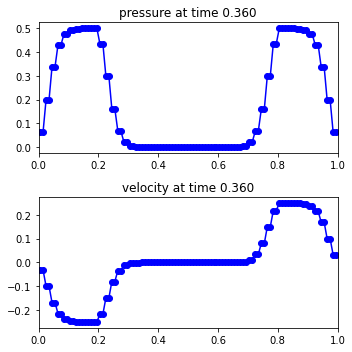

In [210]:
num_cells = 100
dx = (xupper - xlower)/num_cells

# cell centers, including one ghost cell on either side:
x = arange(xlower-dx/2, xupper+dx, dx)

print('including 2 ghost cells, the grid has %i cells' % len(x))

#P0 = exp(-150*(x-0.5)**2)
P0 = where(logical_and(x>0.4,x<0.6), 1., 0.)

U0 = zeros(x.shape)
#U0 = -P0 / Z0  # only left-going wave
#U0 = P0 / Z0  # only right-going wave

t0 = 0.
fig = figure(figsize=(5,5))
plotQ(P0,U0,t0)

dt = 0.009
cfl = c0*dt/dx
nsteps = 40
tn = t0 + nsteps*dt
print('Using dt = %.4f, cfl = %.2f, taking %i steps to time %.3f' \
      % (dt,cfl,nsteps,tn))

Pn,Un = time_stepper(t0, P0, U0, dt, nsteps, LxF_step)
fig = figure(figsize=(5,5))
plotQ(Pn,Un,tn)

## Make an animation:

This will only work if you were able to import animation_tools.

In [202]:
# Using grid points, dt, cfl, etc. from above.

# initial conditions from above:
tn = 0.
Pn = P0.copy()
Un = U0.copy()

nsteps = 40
nplot = 4.  # how frequently to produce a plot
figs = []  # to accumulate figures for animation

for n in range(0,nsteps):
    tn = n*dt
    if mod(n,nplot)==0:
        fig = figure(figsize=(5,5))
        plotQ(Pn,Un,tn)
        figs.append(fig)
        close(fig)
    if n < nsteps-1:
        # take the next step
        Pn, Un = Godunov_step(Pn,Un,dt)


anim = animation_tools.animate_figs(figs, figsize=(5,5))
HTML(anim.to_jshtml())

NameError: name 'animation_tools' is not defined